In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_folder = './Data/' # all my data is in one folder 
path_sources_final='sources_final.csv'
path_control_grp='sources_1.csv'
path_df1='df_1.csv'
path_df2='df_2.csv'

In [3]:
#getting our necessary datasets
df_sources_final=pd.read_csv(data_folder + path_sources_final) #maps channel_id to extreme grp corresponding
df_1=pd.read_csv(data_folder + path_df1)
df_2=pd.read_csv(data_folder + path_df2)

In [4]:
#combining the two dataframes from the two folders 
#(should do it right from the begining? I was afraid it would slow things to have a dataframe so big)
df=pd.concat([df_1, df_2],ignore_index=True)

In [5]:
#extracting only necessary columns
df_sources=df_sources_final[["Category", "Id"]]
df_sources.rename(columns = {'Id':'channel_id'}, inplace = True)

C:\Users\anyam\AppData\Local\Temp\ipykernel_29116\2487438044.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sources.rename(columns = {'Id':'channel_id'}, inplace = True)


In [6]:
#checking for NaN values
print("there are", len(df_sources[df_sources.isnull().any(axis=1)]), "Nan values in df_source.")
#checking for NaN values
print("there are", len(df[df.isnull().any(axis=1)]), "Nan values in df.")

there are 0 Nan values in df_source.
there are 0 Nan values in df.


In [7]:
#checking if nb of channels in df_1 is the same as in df_sources
print(len(pd.unique(df['channel_id'])), len(pd.unique(df_sources['channel_id'])))

697 676


In [8]:
#we have more channels in df than in df_sources but the difference is small
df_final=df.merge(df_sources, how='left', on='channel_id')

In [9]:
#overwriting the category for the channels belonging to the control group
df_control_=pd.read_csv(data_folder + path_control_grp) #maps channel_id to extreme grp corresponding

In [10]:
#list of channels belonging to control grp
list_control_=(df_control_[df_control_["Data Collection step"]=='control'].Id).tolist()

In [11]:
df_final.loc[df_final["channel_id"].isin(list_control_), "Category"] = 'control'

In [12]:
#checking for NaN values
nb_Nan=len(df_final[df_final.isnull().any(axis=1)])
print("there are", nb_Nan, "Nan values which corresponds to", nb_Nan*100/len(df_final), "% of the dataframe")

there are 1998 Nan values which corresponds to 0.3853698335271755 % of the dataframe


In [13]:
#very little Nan values, we won't be using channels where the category is Nan (unknown)

In [14]:
#Notice None means "not associated to anything" and not "Nan" 
df_final.Category.value_counts()

control                  332815
Alt-lite                  63667
Intellectual Dark Web     34252
PUA                       27508
MGTOW                     19932
NONE                      14793
Alt-right                 14208
MRA                        5613
Incel                      3468
PUA                         209
Name: Category, dtype: int64

In [15]:
# correct the duplicated category
df_final.loc[df_final.Category == 'PUA ', 'Category'] = 'PUA'

#MGTOW men going their own way, anti feminist misogynistic politic group

#MRA men's rights activist (again anti feminist)

#Incel a member of an online community of young men who consider themselves unable to attract women sexually, 
#typically associated with views that are hostile towards women and men who are sexually active:

#Pick up : online community sharing tips on how to pick up women


## Analysis of toxicity level through time

Now that we have our dataframe and all the values we want we can start our analysis. 
We're keeping only Alt-lite, Alt-right, Intellectual Dark Web channels and control channels. 

In [16]:
# Some lists
# all channel categories
list_all_cat = df_final.Category.dropna().unique().tolist()
list_all_cat.remove('NONE')
# selection of channel categories
list_categories = ['Alt-lite', 'Alt-right', 'Intellectual Dark Web', 'control']
# subcategories of toxicity
list_subcat_tox = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat', 'sexual_explicit']
list_subcat_tox_titles = ['Severe toxicity', 'Obscene', 'Identity attack', 'Insult', 'Threat', 'Sexual explicit']
# all categories of toxicity
list_all_tox = ['toxicity'] + list_subcat_tox
list_all_tox_titles = ['Toxicity'] + list_subcat_tox_titles

In [17]:
# change the format of the upload date, and add a column of month created
df_final.upload_date = pd.to_datetime(df_final.upload_date, format='%Y%m%d')
df_final["month_created"] = df_final.upload_date.apply(lambda x: pd.to_datetime(x.strftime('%Y-%m')))

# all categories have data until April 2019. Therefore we consider only the data until then:
df_final = df_final[df_final.upload_date < pd.to_datetime("2019-05")]

# we study the dataframe of categories in list_categories
df_final_cat=df_final.loc[df_final['Category'].isin(list_categories)]

## Number of comments per month
We see in the first graph that the data is quite noisy before 2014. Then, we show that there is more content to study from 2014, which explains why the data is not stable before. Therefore, we will only study the toxicity level from 2014 until April 2019.

Text(0.5, 0, 'Month')

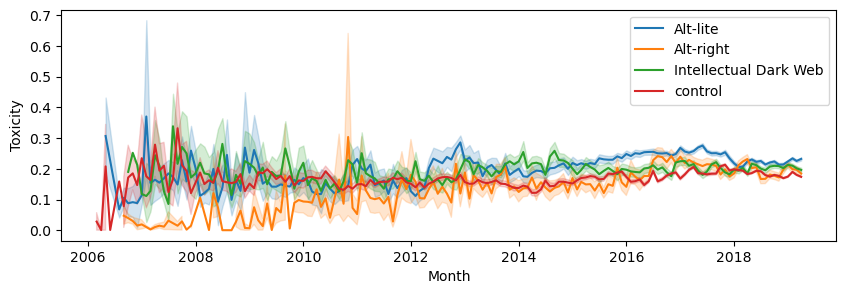

In [18]:
fig, axs = plt.subplots(1, 1, figsize=(10,3))

for category in list_categories:
    sns.lineplot(x="month_created", y="toxicity", data=df_final_cat[df_final_cat['Category'] == category],
            label=category)
axs.set_ylabel("Toxicity")
axs.set_xlabel("Month")

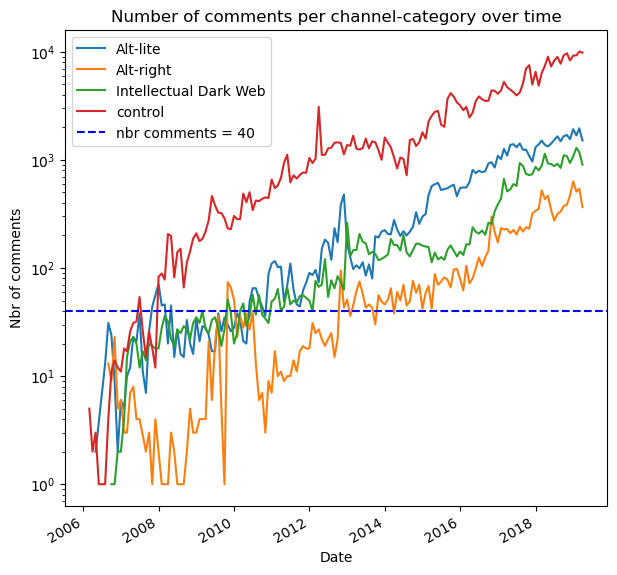

In [19]:
#plot number of comments per month per category: 
fig, axs = plt.subplots(1,1, figsize=(7,7), sharex=True)

for category in list_categories:
        df_final_cat.loc[df_final_cat['Category'] == category, 'month_created'].value_counts().plot(kind = 'line', ax=axs, logy=True)

axs.axhline(y=40, linestyle = '--', color='b')
axs.set_ylabel("Nbr of comments")
axs.set_xlabel("Date")
axs.set_title("Number of comments per channel-category over time")
axs.legend(list_categories + ['nbr comments = 40'])

From 2014, we have at least 40 comments per category per month (see horizontal line). We presume it is enough to make analysis on the overall toxicity of the comments. Therefore, from now on we will consider data from January 2014 until April 2019.

In [20]:
df_after2014 = df_final_cat[df_final_cat.upload_date >= pd.to_datetime("2014-01")]

## Analysis: each category of toxicity
In the period defined before, we compare the toxicity levels in between each channel-category.

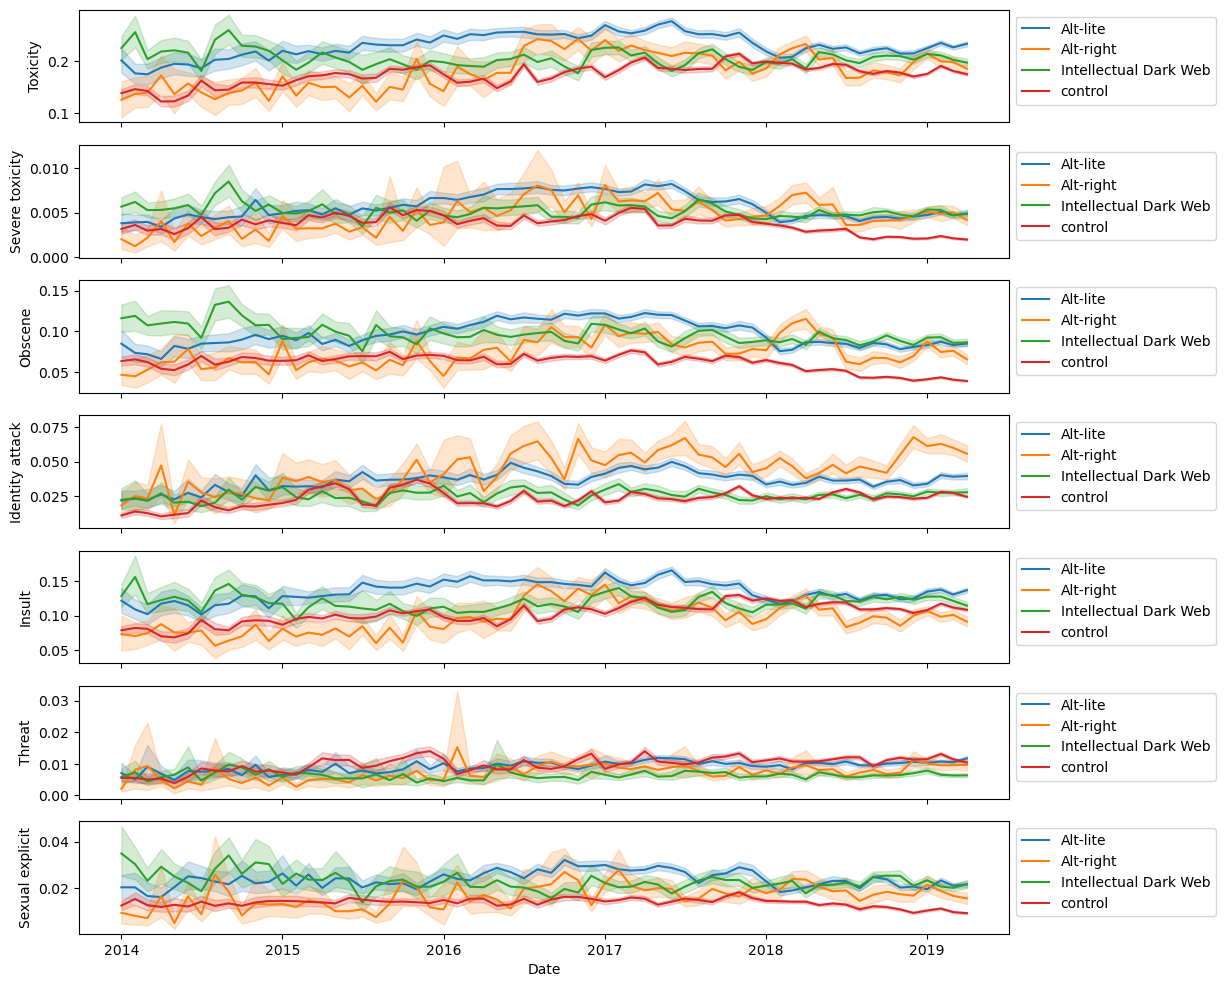

In [21]:
# prints the categories of toxicity over time. 
# takes about 45 sec to run

fig, axs = plt.subplots(7,1, figsize=(12,12), sharex=True)

for index, subcat in enumerate(list_all_tox):
    for category in list_categories:
        sns.lineplot(x="month_created", y=subcat, data=df_after2014[df_after2014['Category'] == category],
            label=category, ax = axs[index])
    axs[index].set_ylabel(list_all_tox_titles[index])
    axs[index].set_xlabel("Date")
    sns.move_legend(axs[index], "upper left", bbox_to_anchor=(1, 1))


For each category of toxicity, we observe different behaviours. 
* Toxicity: alt-lite has become more toxic than other categeries.
* Severe toxicity: (SMALL SCALE!) since the results are very small, we can conclude that none of the channel-category are severly toxic.
* Obscene: all channel categories became higher than media, the control group.
* Identity attack: Alt-right on the top, then alt-lite. Then IDW has approximately the same score as the control group.
* Insult: Alt-lite is above control group.
* Threat: (SMALL SCALE!) However pick for alt-right in 2016.
* Sexual Explicit: (SMALL SCALE!) right wing is above control group. 

## Analysis: each channel-category
Now, we compare the behaviours of the toxicity features within each channel-category.

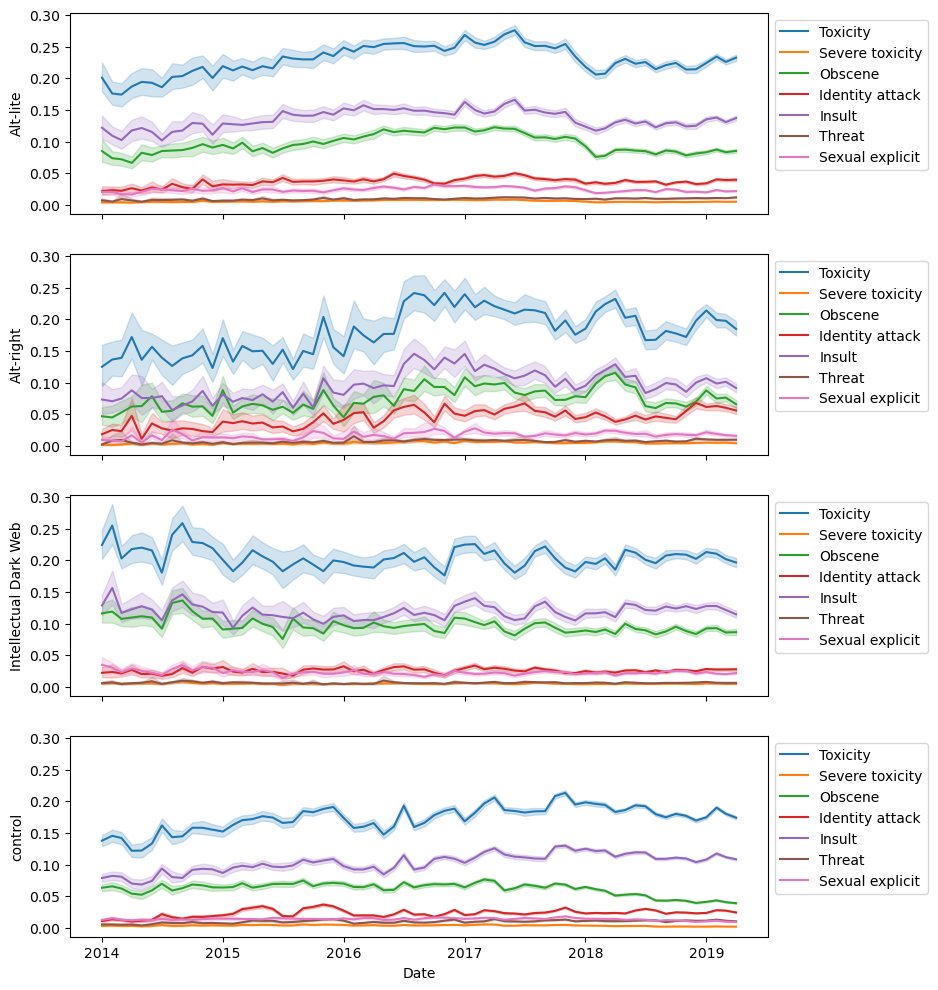

In [22]:
fig, axs = plt.subplots(4,1, figsize=(9,12), sharex=True, sharey=True)

for i, category in enumerate(list_categories):
    for j, subcat in enumerate(list_all_tox):
        sns.lineplot(x="month_created", y=subcat, data=df_after2014[df_after2014['Category'] == category],
            label=list_all_tox_titles[j], ax = axs[i])
    axs[i].set_ylabel(list_categories[i])
    axs[i].set_xlabel("Date")
    sns.move_legend(axs[i], "upper left", bbox_to_anchor=(1, 1))

Overall the 4 channel-categories, the three main subcategories of toxicity that are signifcant are toxicity, insult and obscene.
* Alt-lite: we see a small increase of the three main subcategories mentionned above, until 2018, where a drop is observed. The values might have dropped because of the #Metoo movement, starting in 2017 as a way to draw attention on the magnitude against sexual abuse and harassment. Then the values are quite stable.
* Alt-right: an steep increase is observed mid 2016 in toxicity, insult, obscene. It coincides with the election of Donald Trump in the U.S. Indeed, June 2015, he announced that he would be a candidate in the U.S presidential election of 2016. In November 2016, he won the election. Also youtube didn't moderate the comments, following the Russian interference in the 2016 U.S. elections. We also see a pick in the first quarter of 2018. 
* IDW: rather constant.
* control: a very light increase of toxicity and insult since 2014. A decrease of obscene from 2018.

Link the behaviours to events, see hateful events of the last decade in https://www.adl.org/resources/report/decades-top-10-incidents-hate 

october 2018: Pittsburgh synagogue shooting is deadliest attack on Jews in U.S. history

# Study of the top 25 videos per channel-category